[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints 

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state, and introduce human feedback. 

## Goals

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using the `interrupt` function](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `interrupt` function).

Let's create a graph where an `interrupt` is called based upon length of the input.

In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langgraph langchain_openai langgraph_sdk

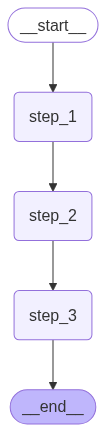

In [ ]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
# from langgraph.errors import NodeInterrupt
from langgraph.types import interrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise interrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters. 

In [3]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


In [4]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the `Interrupt` is logged to state.

In [5]:
print(state.tasks)

(PregelTask(id='2ad26602-5675-ea8f-f07e-5c8e352845cc', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', id='8b20ba775f1eb8e15dd5478ca29b0989'),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [6]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [7]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [8]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07ef71-3c79-624c-8002-ccde390745e8'}}

In [9]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### Usage with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

In [10]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

We connect to it via the SDK.

In [11]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

CancelledError: 

In [ ]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])

In [ ]:
current_state['next']

In [ ]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

In [ ]:
# Check LangGraph version using the correct method
try:
    from importlib.metadata import version
    langgraph_version = version("langgraph")
    print(f"LangGraph version: {langgraph_version}")
except ImportError:
    # Fallback for older Python versions
    import pkg_resources
    try:
        version = pkg_resources.get_distribution("langgraph").version
        print(f"LangGraph version: {version}")
    except pkg_resources.DistributionNotFound:
        print("LangGraph version not found")
except Exception as e:
    print(f"Could not get version: {e}")

In [ ]:
from langgraph.types import interrupt

def human_node(state: State):
    value = interrupt(
        {
            "text_to_revise": state["some_text"]
        }
    )
    return { "some_text": value }

graph = graph_builder.compile(checkpointer=checkpointer)
